<a href="https://colab.research.google.com/github/Ali-Ehab-pixel/Lung-Cancer-Classification-Using-CNN/blob/main/New_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading Dataset from Kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aliehab2005","key":"76c82c58ff371648d9ace927bc896623"}'}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Requirements Used: -

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D , Flatten, InputLayer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

Lung Cancer Classification Pipeline: -

1. Data Acquisition:
*   Data Source -> https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images/data
*   Data Consists of 5000 image, after Augmentation 15000.
---------------------------------------------------------------------
2.  Data Preprocessing:
*   Resizing images to 128,128.
*   32 image per batch.
*   Scaling images.
*   Augmentation Using ImageDataGenerator
---------------------------------------------------------------------
3. Model Building:
*   Consisted of 3 Convolutional, Pooling Layers
*   Flatten & 2 Dense Layers with activation relu
*   Output Layer softmax activation.
*   Model Trained for 50 epoch.
*   Applied early stopping callback with patience 3.
*   Stopped at epoch 16, best weight is epoch 13
---------------------------------------------------------------------
4. Model Evaluation:
*   Model performed 0.95 val_accracy, 0.1 val_loss
*   True Predictions for Benign & squamous.
*   1 False Prediction in adenocarcinoma class.
---------------------------------------------------------------------

# Loading Data & Defining Classes

In [26]:
data = '/content/dataset'
print("Data Loaded Successfully !")

categories = ['benign','squamous_cell_carcinoma','adenocarcinoma']

Data Loaded Successfully !


## Displaying random images from the classes

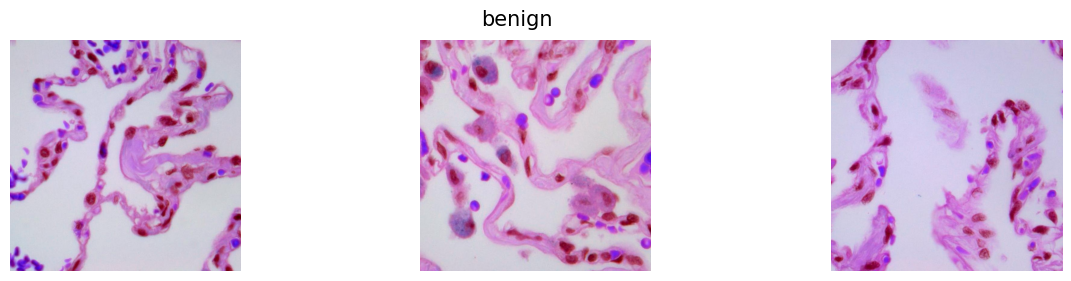

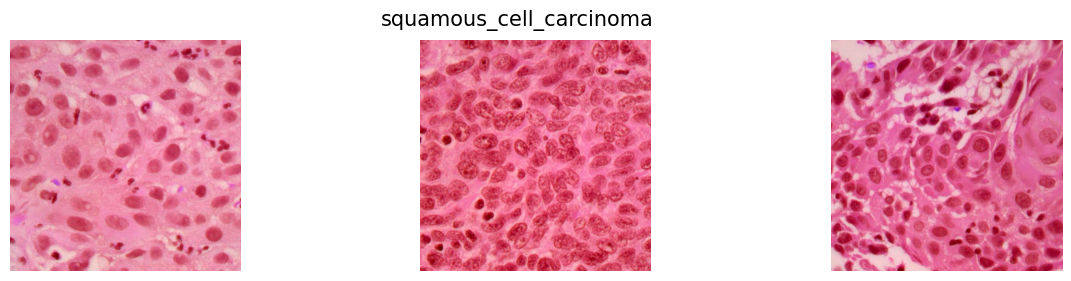

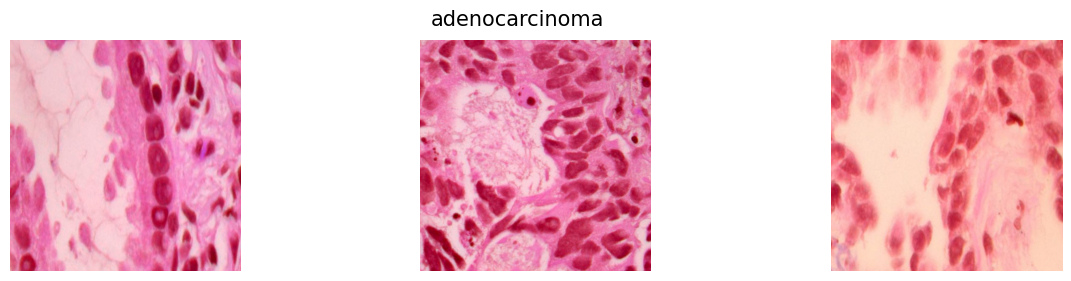

In [27]:
for cat in categories:
  path = os.path.join(data, cat)
  images = os.listdir(path)

  fig, ax = plt.subplots(1, 3, figsize=(15 , 3))
  fig.suptitle(f'{cat}', fontsize=15)

  for i in range(3):
    img_name = images[np.random.randint(0, len(images))]
    img_path = os.path.join(path, img_name)
    img_array = cv2.imread(img_path)

    ax[i].imshow(img_array)
    ax[i].axis('off')

## Defining Classes paths for Augmentation

In [28]:
data_paths = {
    'benign':'/content/dataset/benign',
    'squamous_cell_carcinoma':'/content/dataset/squamous_cell_carcinoma',
    'adenocarcinoma':'/content/dataset/adenocarcinoma',

}

## Image preprocessing parameters

In [29]:
img_height, img_width = 128, 128
batch_size=32

# Data Augmentation

In [30]:
data_gen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    seed=seed
)

## Data Splitting

In [31]:
train_data = data_gen.flow_from_directory(
    directory = os.path.dirname(list(data_paths.values())[0]),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=seed
)
val_data = data_gen.flow_from_directory(
    directory=os.path.dirname(list(data_paths.values())[0]),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    seed=seed
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


# Model Building

In [32]:
model = Sequential()

model.add(InputLayer(input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,091 (12.64 MB)

 Trainable params: 3,313,091 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

# Callbacks & Compile

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'],
    loss='categorical_crossentropy'
)

## Training

In [34]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[early_stop]
)
best_epoch = early_stop.stopped_epoch - early_stop.patience
print(f"Best epoch: {best_epoch}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 113s 292ms/step - accuracy: 0.7412 - loss: 0.5459 - val_accuracy: 0.8837 - val_loss: 0.2609
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 281ms/step - accuracy: 0.8890 - loss: 0.2856 - val_accuracy: 0.9077 - val_loss: 0.2356
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 284ms/step - accuracy: 0.8963 - loss: 0.2495 - val_accuracy: 0.8960 - val_loss: 0.2365
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 109s 290ms/step - accuracy: 0.9145 - loss: 0.2209 - val_accuracy: 0.9333 - val_loss: 0.1727
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 105s 280ms/step - accuracy: 0.9238 - loss: 0.1992 - val_accuracy: 0.8943 - val_loss: 0.2392
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 106s 283ms/step - accuracy: 0.9164 - loss: 0.2090 - val_accuracy: 0.9390 - val_loss: 0.1483
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 107s 286ms/step - accuracy: 0.9298 - loss: 0.1677 - val_accuracy: 0.9453 - val_loss: 0.1381
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 110s 292ms/step - accuracy: 0.9358 -

# Model Evaluation

In [35]:
val_loss, val_acc = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 228ms/step - accuracy: 0.9659 - loss: 0.0806
Validation Loss: 0.08553968369960785
Validation Accuracy: 0.9616666436195374


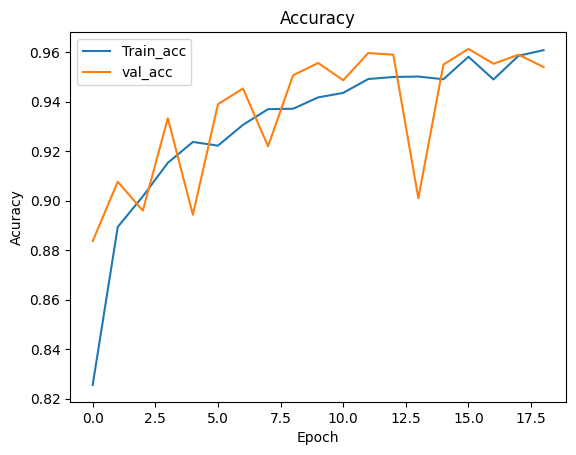

In [36]:
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Acuracy')
plt.title("Accuracy")
plt.show()

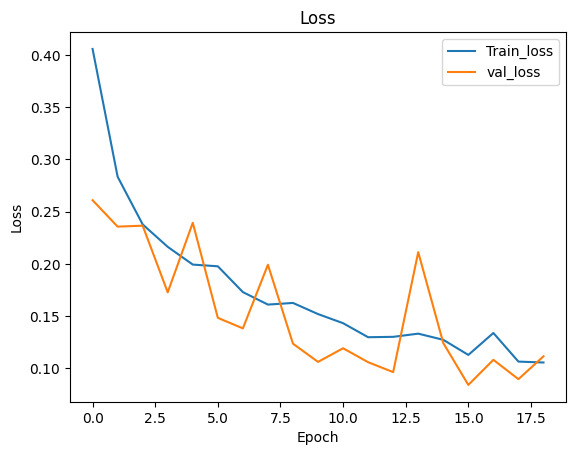

In [37]:
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss")
plt.show()

# Predicting on an image from google

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step


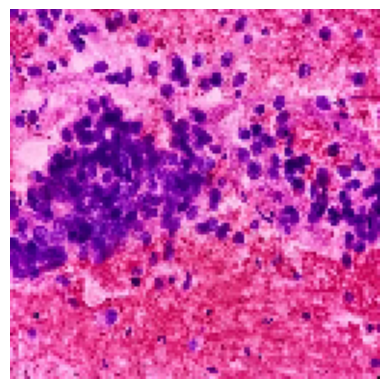

Predicted Category: benign


In [38]:
from keras.preprocessing.image import load_img, img_to_array

img_path = '/content/lungs-adenocarcinoma-malignant-cell-smear-show-cellular-material-of-atypical-epithelial-cells.png'
img = load_img(img_path, target_size=(img_height, img_width))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_array)
category = list(train_data.class_indices.keys())[np.argmax(predictions)]
plt.imshow(img_array[0])
plt.axis('off')
plt.show()
print(f"Predicted Category: {category}")

## Adjusting True Labels

In [39]:
images, labels = next(val_data)

predictions = model.predict(images)

predicted_classes = predictions.argmax(axis=1)

true_classes = labels.argmax(axis=1)
correct_predictions = 0
for i in range(len(images)):
    true_label = list(val_data.class_indices.keys())[true_classes[i]]
    predicted_label = list(val_data.class_indices.keys())[predicted_classes[i]]
    if true_classes[i] == predicted_classes[i]:
        correct_predictions += 1
    print(f"True label: {list(val_data.class_indices.keys())[true_classes[i]]}, Predicted: {list(val_data.class_indices.keys())[predicted_classes[i]]}\n")


accuracy = correct_predictions / len(images) * 100
print(f"\nAccuracy: {accuracy:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
True label: benign, Predicted: benign

True label: adenocarcinoma, Predicted: adenocarcinoma

True label: adenocarcinoma, Predicted: adenocarcinoma

True label: benign, Predicted: benign

True label: adenocarcinoma, Predicted: adenocarcinoma

True label: squamous_cell_carcinoma, Predicted: squamous_cell_carcinoma

True label: adenocarcinoma, Predicted: adenocarcinoma

True label: adenocarcinoma, Predicted: adenocarcinoma

True label: squamous_cell_carcinoma, Predicted: squamous_cell_carcinoma

True label: squamous_cell_carcinoma, Predicted: squamous_cell_carcinoma

True label: adenocarcinoma, Predicted: adenocarcinoma

True label: benign, Predicted: benign

True label: squamous_cell_carcinoma, Predicted: squamous_cell_carcinoma

True label: squamous_cell_carcinoma, Predicted: squamous_cell_carcinoma

True label: benign, Predicted: benign

True label: benign, Predicted: benign

True label: adenocarcinoma, Predicted: adenocarcinoma

True label: aden

## Predicted Labels & confusion matrix

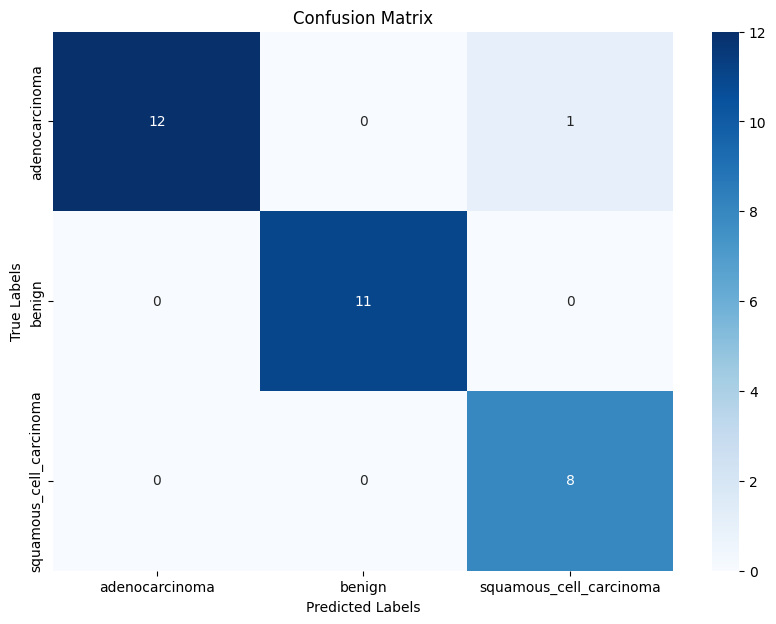

In [40]:
class_labels = list(val_data.class_indices.keys())
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Saving Model

In [41]:
model.save('lung_cancer_model.h5')
print("Model Saved Successfully !")

Model Saved Successfully !


# Streamlit App

In [42]:
%%writefile app.py

import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

def load_my_model():
  return load_model()

model = load_my_model()

img_height, img_width = 128,128
class_labels = ['adenocarcinoma','squamous_cell_carcinoma','benign']

st.title("Lung Cancer Classification")
st.write("Upload an image to classify its category.")

uploaded_file = st.file_uploader("Choose an Image...", type=['jpg','jpg','png'])

if uploaded_file is not None:

  image = Image.open(uploaded_file)
  st.image(image, caption='Uploaded Image', use_column_width=True)

  img = image.resize(img_height, img_width)
  img_array = img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)

  predictions = model.predict(img_array)
  predicted_class = class_labels[np.argmax(predictions)]
  confidence = np.max(predictions) * 100

  st.write(f"Predicted Category: {predicted_class}")
  st.write(f"Confidence: {confidence:.2f}%")

Writing app.py
